In [1]:
from pathlib import Path
import os
import sys 

path_dcf = str(Path(os.path.abspath('.')).resolve().parent)
sys.path.append(path_dcf)

from config import *
from algorithms.dcf_distance_map import DCF
from utils import *
from algorithms.utils_dilated_tubules import *
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import cv2

None


/pasteur/appa/homes/ahabis/miniconda3/envs/scribble/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/pasteur/appa/homes/ahabis/miniconda3/envs/scribble/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/local/scratch/tmp/ipykernel_4025786/1246545848.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but wa

## Choose a Slide from the dataset and a dilated tubule from the given slide

In [2]:
nb_slide = 1
nb_support_dilated_tubule = 8
nb_query_dilated_tubule = 20

In [3]:
path_images = os.path.join(path_data,'images')
path_masks = os.path.join(path_data,'masks')
annotations = pd.read_csv(os.path.join(path_annotations,'annotations.csv'), index_col=0)
contour_inits = np.load(os.path.join(path_data, 'contour_init.npy'), allow_pickle=True).item()
all_filenames = np.unique(list(annotations['slide']))
filename = np.unique(list(annotations['slide']))[nb_slide]
annotations = annotations[annotations['slide'] == filename]

TypeError: expected str, bytes or os.PathLike object, not NoneType

### Instanciate the object DCF one-shot

In [ ]:
dcf = DCF(nb_points=100,
            n_epochs=100,
            nb_augment=100,
            isolines=np.array([0.0, 1.0]),
            learning_rate=5e-1,
            clip=1e-1,
            sigma=5,
            weights=0.9,
            exponential_decay=0.999,
            thresh=1e-2,
        )

### Show the Support dilated tubule and the annotation of the support

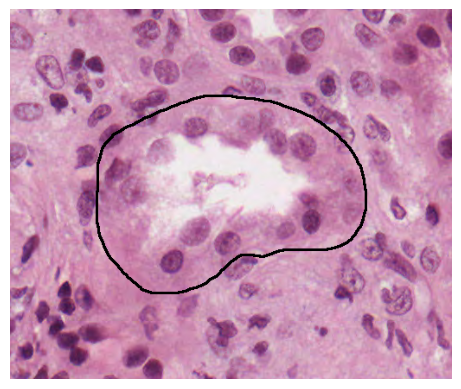

In [69]:
filename_img = row_to_filename(annotations.iloc[nb_support_dilated_tubule])
img_support = tifffile.imread(os.path.join(path_images,filename_img))
mask_support = tifffile.imread(os.path.join(path_masks,filename_img))
contour_support = np.squeeze(cv2.findContours(mask_support.astype(np.uint8),
                                 cv2.RETR_TREE,
                                 cv2.CHAIN_APPROX_SIMPLE)[0][0])
new_img = cv2.drawContours(img_support,
                        [contour_support],
                        0,
                        color = 1,
                        thickness=2)

plt.axis('off')
plt.imshow(new_img)

In [61]:
contour_support = np.squeeze(cv2.findContours(mask_support.astype(np.uint8),
                                 cv2.RETR_TREE,
                                 cv2.CHAIN_APPROX_SIMPLE)[0][0])

### Fit the one shot DCF

In [62]:
dcf.fit(img_support,
        contour_support,
        augment = True)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


### Predict on the query

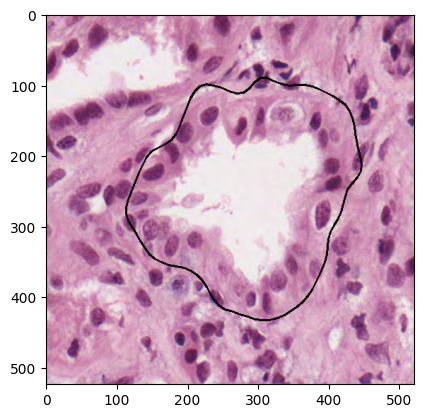

In [66]:
filename_img = row_to_filename(annotations.iloc[nb_query_dilated_tubule])
img_test = tifffile.imread(os.path.join(path_images,filename_img))
contour_init = contour_inits[filename_img]
contour_init = preprocess_contour(contour_init,img_test)
contours, score, tots, energies = dcf.predict(img_test,
                                               contour_init)
tots[tots == 0] = 1e100
x = np.argmin(tots)
contour_to_display = (np.expand_dims(contours[-1], 1)).astype(int)
new_img = cv2.drawContours((((img_test/np.max(img_test))*255).astype(np.uint8)).copy(),
                        [contour_to_display],
                        0,
                        color = 1,
                        thickness=2)
plt.imshow(new_img)
plt.show()


### This cell save the images of the evolution of the contour over time in folder_images_paper

In [67]:
import matplotlib
cmap = matplotlib.cm.get_cmap('cool')

colors = [cmap(u)[:-1] for u in np.linspace(0,1,dcf.n_epochs+1)]
colors = (np.array(colors)*255).astype(np.int32).tolist()

tots = []
imgs = []

for i, contour in enumerate(contours):

    contour_to_display = (np.expand_dims(contour, 1)).astype(int)
    
    new_img = cv2.drawContours((((img_test/np.max(img_test))*255).astype(np.uint8)).copy(),
                               [contour_to_display],
                               0,
                               color = colors[0],
                               thickness=3)
    plt.imsave(os.path.join('folder_images_paper',filename_img.split('.')[0]+'_'+str(i)+'.png'),new_img)


/tmp/ipykernel_588579/4199990975.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool')


### This cell plot the evolution of the energies by (isoline, scale) over time

In [1]:
# ener = np.squeeze(energies.cpu().detach().numpy())                                                
# isolines = dcf.isolines.cpu().detach().numpy()
# for scale in range(5):
#     for index, isoline in enumerate(isolines):
#         plt.plot(np.arange(dcf.n_epochs),ener[:,scale,index],label = 'isoline '+str(isoline))
#     plt.title('evolution of the energies at scale: ' +str(scale+1))
#     plt.xlabel('step')
#     plt.ylabel('energie value')
#     plt.legend()
#     plt.show()


### This cell plot the repartition of the annotation over the different slides

In [ ]:
# annotations = pd.read_csv(os.path.join(path_annotations,'annotations.csv'), index_col=0)
# annotations = annotations.replace(['dilated_tubule','fake_tubule'], [1,0])
# dt_annotations = annotations[['image','term']].groupby('image').sum()
# dt_annotations.columns = ['number of dilated tubules']
# all_annotations = annotations[['image','term']].groupby('image').count()
# all_annotations.columns = ['number of annotations']

# dataset_stats = pd.concat([dt_annotations,all_annotations], axis = 1)
# dataset_stats['number of false dilated_tubule'] = dataset_stats['number of annotations'] - dataset_stats['number of dilated tubules']
# dataset_stats['image'] = dataset_stats.index
# dataset_stats = dataset_stats.reset_index(drop = True)
# dataset_stats['image'] = dataset_stats['image'].apply(lambda x: x.split('.')[0])
# dataset_stats
# # dataset_stats['image'] = dataset_stats.index.apply(lambda x : x.split('.')[0])

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1)

# plt.figure(figsize = (10,10))
# # plotting columns

# ax = sns.barplot(x=dataset_stats['image'],
#                  y=dataset_stats['number of annotations'],
#                  color = np.array([207,105,138])/255,
#                  label = 'n° of annotations')

# ax = sns.barplot(x=dataset_stats['image'],
#                  y=dataset_stats['number of dilated tubules'],
#                  color = np.array([137,44,80])/255,
#                  label = 'n° of dilated tubules')
 
# # renaming the axes
# ax.set_xlabel("Slide",fontsize = 20)
# ax.set_ylabel("N° of instances",fontsize = 20)
# plt.legend(fontsize = 20)

# # visualizing illustration
# plt.show()
